# Coronory Artery Disease Project
## Exploratory analysis
### Prediction of heart disease given 14 variables

For this analysis we use the Cleveland "Coronary Artery Disease" dataset found on the UCI Machine Learning Repository
at the following location:

<a href=https://archive.ics.uci.edu/ml/datasets/Heart+Disease>Heart Disease Dataset</a>

The objective of the analysis is to use statistical learning to identify factors associated with Coronary Artery
Disease as indicated by a coronary angiography interpreted by a Cardiologist.

According to the paper by (Detrano et al., 1989) the data represents data collected for 303 patients referred for
coronary angiography at the Cleveland Clinic between May 1981 and September 1984. The 13 independent/ features
variables can be divided into 3 groups as follows:

Routine evaluation (based on historical data):
* ECG at rest
* Serum Cholesterol
* Fasting blood sugar

Non-invasive test data (informed consent obtained for data as part of research protocol):
* Exercise ECG
    * ST-segment peak slope (upsloping, flat or downsloping)
    * ST-segment depression
* Excercise Thallium scintigraphy (fixed, reversible or none)
* Cardiac fluoroscopy (number of vessels appeared to contain calcium)

Other demographic and clinical variables (based on routine data):
* Age
* Sex
* Chest pain type
* Systolic blood pressure
* ST-T-wave abnormality (T-wave abnormality)
* Probably or definite ventricular hypertrophy (Este's criteria)

The dependent/ response variable was the angiographic test result indicating a >50% diameter narrowing.

Detrano et al created 352 logistic regression models based on different combinations of the previously discussed
13 variables. Depending on information available in the test dataset one of these models was applied during model
validation.

Unfortunately the the paper by (Detrano et al., 1989) does not publish extensive model accuracy results such as:
overall accuracy, C-Statistic, precision (positive predictive value), recall (sensitivity) or specificity. The
model was however validated on various external datasets which is very important. The positive predictive value
(precision) is reported for a range of probability cut-off points for the various test sets. The various data sets
have widely varying prevalence (38% - 81%), and hence te positive predictive value likewise varies widely between the
reported tests.

From these results one can see that the model was capable of a Precision of approximately 75% for datasets closely
matching the Cleveland dataset in terms of disease prevalence within the test set.

We are going to replicate the analysis by performing a logistic regression and will perform a validation study to
confirm results obtained by (Detrano et al., 1989) in terms of model accuracy. Furthermore we will do an analysis of
significance of the various logistic regression features as means of classifying feature importance.

Subsequent to this analysis we will use an ensemble model (Random Forest) to create feature importance classifications
to validate the regression findings. We will also apply our learnings to a Neural Network, to assess performance on
the smaller dataset i.e. after features selection has been applied.

We aim to achieve this by following the Machine Learning pipeline approach of deploying a variety of ML techniques to
build a predictive model and analyse its results. In the process we hope to gain valuable insights. The various steps
in the process are as follows (not necessarily in this order):

- Load data
- Prepare data
    - Clean data
        - Missing values
        - Outliers
        - Erroneous values
    - Explore data
        - Exploratory descriptive analysis (EDA)
        - Correlation analysis
        - Variable cluster analysis
    - Transform Data
        - Engineer features
        - Encode data
        - Scale & normalise data
        - Impute data
        - Feature selection/ importance analysis
- Build model
    - Model selection
    - Data sampling (validation strategy, imbalanced classification)
    - Hyperparameter optimisation
- Validate model
    - Accuracy testing
- Analysis of results
    - Response curves
    - Accuracy analysis
    - Commentary

Let us start the analysis!

In [7]:
%load_ext autoreload
%autoreload 2

# Import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
import warnings
warnings.filterwarnings("ignore")
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from src.visualization.visualize import plot_confusion_matrix, plot_roc_curve, plot_feature_importance, \
    plot_feature_importance_log, plot_feature_importance_dec, plotVar, plotAge, plotContinuous, plotCategorical
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'mlxtend'

<div class="alert alert-block alert-info">
<b>Load data</b>
</div>

In [ ]:
# Import data
df = pd.read_csv('../data/raw/processed.cleveland.data', header = None, names = ['age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol',
                'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thallium_scint', 'ca_disease'], index_col=None,
                 usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], sep=',', skipinitialspace=True)
df.head(20)
print(df.shape)

The dataset read from csv file has 303 rows and 14 columns.
The data dictionary specified that 303 rows and 75 columns existed.
We therefore have the same number of rows as the data dictionary, but 61 fewer columns...

We were lucky that the data was already pre-processed, and this can be observed from the subset of data displayed
appearing very clean. Hopefully not much further cleaning would be required.

We created a data dictionary for the data is as follows:

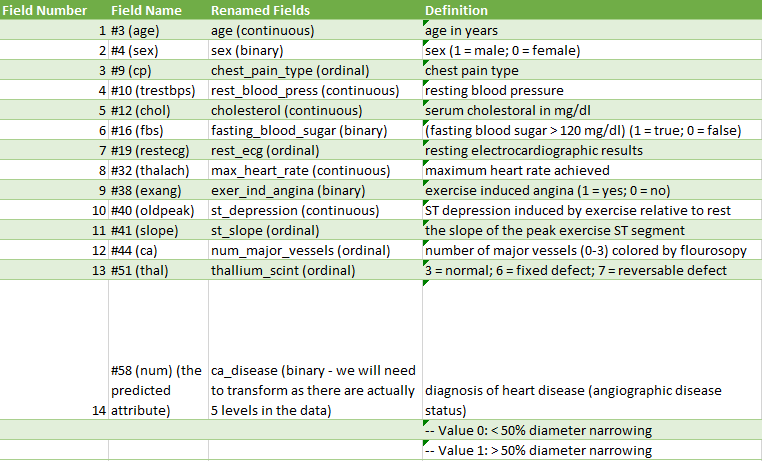

The original field names were not very informative. We therefore renamed the fields based on information gathered
from the article by Detrano et al.

Let us explore the data!

<div class="alert alert-block alert-info">
<b>Clean data</b>
</div>

In [ ]:
# Type of data
print(df.info())

From the output we observe that we have twelve numeric columns and two "object" columns. The data dictionary
however specifies that all fields are numeric. This means that Python could not convert two numeric variables
(num_major_vessels and thallium_scint) to numeric columns due to their contents being non-numeric. Let us investigate.

In [8]:
# Find out what types of data is stored in object column. Use simple regex. Leading number omitted not catered for.
# Future improvement.
r = re.compile(r'\d+[.,]\d*')
df.num_major_vessels.apply(lambda x: bool(r.match(x))).value_counts()
df.thallium_scint.apply(lambda x: bool(r.match(x))).value_counts()

df.loc[df.num_major_vessels.apply(lambda x: bool(r.match(x))) == False]
df.loc[df.thallium_scint.apply(lambda x: bool(r.match(x))) == False]

NameError: name 'df' is not defined

We can see that there are 4 non-numeric fields in num_major_vessels and 2 in thallium_scint. These values are all '?'.
It is a reasonable assumption that these are missing values from data entry due to the placeholder. We will therefore
clean the data by replacing these values with NaN and converting all character values to decimal.

In [ ]:
# Replace all non numeric data with NaN, convert strings to numbers.
df_clean = df.apply(pd.to_numeric, errors='coerce')

Let us see if that worked! We should now have only decimal and null values.

In [ ]:
# Number of null values
print(df_clean.isnull().sum())

# Actual null values
df_clean[df_clean.isnull().any(axis=1)]


Looks great we have 6 null values, 4 in num_major_vessels and 2 in thallium_scint as expected. We can also observe
that none of the other fields contain any null values. Seeing as there are only a handful of these values and none
in the response variable, it is not necessary to remove these records from the dataset at this stage.

We now have a dataset with 303 records and 14 numeric fields, as per the data dictionary, there are still 6 missing
values in the 'num_major_vessels' and 'thallium_scint' fields though. Due to the low number of missing values and even
distribution of values in these fields (see explore analysis below) we will now substitute these with median values.

In [ ]:
df_fin = df_clean.copy()
median = df_fin['num_major_vessels'].median()
df_fin['num_major_vessels'].fillna(median, inplace=True)
print("Number of null values in num_major_vessels column: {}".format(df_fin['num_major_vessels'].isnull().sum()))

median = df_fin['thallium_scint'].median()
df_fin['thallium_scint'].fillna(median, inplace=True)
print("Number of null values in thallium_scint column: {}".format(df_fin['thallium_scint'].isnull().sum()))
print("Dataframe dimension: {}".format(df_fin.shape))

Now our set is finally ready for further analysis. We will now look at the distribution of variables and any possible
outliers or heavy tailed distributions.

<div class="alert alert-block alert-info">
<b>Explore data</b>
</div>

We start by looking at the number of unique records per variable. We start here as variables with too little variability
will be discarded from the analysis.

In [9]:
print(df_fin.nunique())

NameError: name 'df_fin' is not defined

There are no columns with only one value. We therefore retain all columns for ML purposes as there is enough
variability to warrant using the data. There are many variables with fewer than 10 levels which could be considered
as categorical. Based on our initial assessment of the data we will work with levels of measurement for the data as
follows:

- age (continuous)
- sex (binary)
- chest_pain_type (ordinal)
- rest_blood_press (continuous)
- cholesterol (continuous)
- fasting_blood_sugar (binary)
- rest_ecg (ordinal)
- max_heart_rate (continuous)
- exer_ind_angina (binary)
- st_depression (continuous)
- st_slope (ordinal)
- num_major_vessels (ordinal)
- thallium_scint (ordinal - needs reordering)
- ca_disease (binary - we will need to transform as there are actually 5 levels in the data)

At this point it seems as if the only nominal data is binary, which means we might not need any One Hot Encoding
initially. We will leave the ordinal data as is for the initial analysis.

It is important to note the large number binary and ordinal variables which indicates that the original continuous
variables have in all likelihood been discretised by the original authors. This could possibly be revisited at a later
later stage by considering the original data.

Next we look at the distribution of the data.

We now extract data according levels of measurement first to ease analysis. We also rename the variables to enable
ease of interpretation.

In [ ]:
# Extract categorical variables for analysis.
df_fin_cat = df_fin.copy()
names_cat = ('sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exer_ind_angina', 'st_slope',
             'num_major_vessels', 'thallium_scint', 'ca_disease')
df_fin_cat = df_fin_cat.loc[:, names_cat]

# Extract continuous variables for analysis.
#df_fin.reset_index(drop=True, inplace=True)
df_fin_con = df_fin.copy()
names_con = ('age', 'rest_blood_press', 'cholesterol', 'max_heart_rate', 'st_depression')
df_fin_con = df_fin_con.loc[:, names_con]

# Plotting label dictionary
plot_cat = [('sex', ['female', 'male']),
              ('chest_pain_type', ['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic']),
              ('fasting_blood_sugar', ['fbs > 120mg', 'fbs < 120mg']),
              ('rest_ecg', ['normal', 'ST T-wave', 'left ventricular']),
              ('exer_ind_angina', ['yes', 'no']),
              ('st_slope', ['upsloping', 'flat', 'downsloping']),
              ('num_major_vessels', ['0', '1', '2', '3']),
              ('thallium_scint', ['normal', 'fixed defect', 'reversible defect']),
              ('ca_disease', ['No CA disease', 'CA disease'])]
plot_con = [('age', 'age in years'),
            ('rest_blood_press', 'blood pressure in mm Hg'),
              ('cholesterol', 'serum cholesterol in mg/d'),
              ('max_heart_rate', 'maximum heart rate achieved'),
              ('st_depression', 'ST depression by exercise relative to rest'),
              ('ca_disease', 'Coronary Artery disease')]

# Extract numeric variables for analysis.
df_fin.reset_index(drop=True, inplace=True)
df_fin_num = df_fin.copy()
names_num = ('age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg',
             'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thallium_scint',
             'ca_disease')
df_fin_num = df_fin_num.loc[:, names_num]

We now consider the response variable.

In [ ]:
#outcome_counts = df_fin_cat.groupby('ca_disease').size()
outcome_counts = df_fin_cat['ca_disease'].value_counts()
print(outcome_counts)

# Plot outcome counts.
ax = sns.barplot(x=outcome_counts.index, y=outcome_counts.values, alpha=0.9)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
#ax.title.set_size(45)
ax.tick_params('y', labelsize = 20);
ax.tick_params('x', labelsize = 20);
plt.title('Frequency Distribution of Outcomes', fontsize=20)
plt.ylabel('Number of Occurrences')
plt.xlabel('Outcome')
plt.show();

The spread of the data is good for classification, as there are a large number of positive cases. If one combines
classes 1, 2, 3 and 4 as suggested there will be a fairly even split between positive and negative outcomes. Let
us confirm if this is the case.

In [10]:
# Transform y variable
df_fin_cat['num_bin'] = df_fin['ca_disease'].apply(lambda x: 1 if x > 0 else 0)

c = df_fin_cat.num_bin.value_counts(dropna=False)
p = df_fin_cat.num_bin.value_counts(dropna=False, normalize=True)
output = pd.concat([c,p], axis=1, keys=['counts', '%'])
print(output)

ax = sns.barplot(x=p.index, y=p.values)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
#ax.title.set_size(45)
ax.tick_params('y', labelsize = 20);
ax.tick_params('x', labelsize = 20);
plt.title('Frequency Distribution of Outcomes', fontsize = 20)
plt.ylabel('Number of Occurrences')
plt.xlabel('Outcome')
plt.show();

NameError: name 'df_fin' is not defined

As expected, the distribution of positive and negative values is balanced with 46% of values denoting a positive
outcome. It is therefore very unlikely that we would need to make allowance for imbalanced classes (by resampling,
boosting or using an alternative ML algorithm such as Boosting) as there is a sufficiently large proportion of
positive outcomes. The sample size of this dataset is however very small i.e. 303, so we will revisit this assumption
once we have done some accuracy testing.

Let us consider the categorical variables.

In [ ]:
# Class level counts for categorical variables.
for variable in names_cat:
    print(df_fin_cat[variable].value_counts())

In [ ]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(3, 3, figsize=(25, 20));
for variable, subplot in zip(names_cat, ax.flatten()):
    subplot.xaxis.label.set_size(34)
    subplot.yaxis.label.set_size(34)
    subplot.tick_params('y', labelsize = 30);
    subplot.tick_params('x', labelsize = 30);
    cp = sns.countplot(x=df_fin_cat[variable], ax=subplot);
plt.tight_layout()

The data looks fine from a modelling perspective as there are no variables with empty classes. We picked up from the
data dictionary that the 'thallium_scint' variable needs to be recoded due to incorrect labelling i.e. the order
does not result in an increasing ordinal value.

It is interesting to note that there are ~30% females and ~60% males. The distribution of chest pain also seems
increase in a linear fashion for this population, with the largest portion of the population suffering from severe
chest pain.

Next, let us consider the continuous variables. We start by looking at age patterns.

In [ ]:
# Continuous density plot
df_fin_num['ca_disease'] = df_fin_num['ca_disease'].apply(lambda x: 1 if x > 0 else 0)

fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), squeeze=False)
_ = plotAge(df=df_fin_num, axes=axes, single_plot=True);

It is clear that individuals suffering from coronary artery disease have a higher average age.

In [ ]:
# 5 number summary.
df_fin_con.describe()

In [ ]:
# Continuous density plot
#df_fin_num['ca_disease'] = df_fin_num['ca_disease'].apply(lambda x: 1 if x > 0 else 0)

fig_continuous, axes = plt.subplots(nrows=len(plot_con)-1, ncols=2, figsize=(15, 22))
_ = plotVar(isCategorical=False, categorical = plot_cat, continuous = plot_con, df=df_fin_num, axes=axes);

The violin plots demonstrate that the distributions for age, maximum HR and ST depression differ between individuals
with and those without ca disease, whereas there is little difference in the distributions for resting BP and
cholesterol.

The violin plot for age against coronary artery disease demonstrates that the age of individuals without ca disease is
evenly spread between the ages of 40 and 65, with some younger patients below the age of 30, whereas individuals with
ca disease are mostly older, with a median age of approx 60 and few, if any, below 30 years of age.

The median maximum HR for individuals without ca disease is higher (\~160) than for individuals with ca disease (\~150),
with a narrower distribution around the mean, whereas individuals with ca disease have a skewed distribution towards
lower maximum HR, with a larger proportion having max HR below 100 than healthy individuals.

The distribution for ST depression is starkly different, with individuals without ca disease having a median ST
depression of 0, with a narrow distribution around the mean, and a small proportion having ST depression between 1 and 2.

In contrast, individuals with ca disease follow a broader distribution around a median of ~1.5, with a substantial
proportion of individuals with ST depression >2. Resting blood pressure and cholesterol do not appear to be
significantly different between patients with and without ca disease, with both groups having similar median resting
BP (around 125mmHg) and cholesterol (200-250) and roughly even spread around the point estimates. A small number of
individuals with ca disease have much higher resting BP of >200, whereas none of those without ca disease have a
resting BP >200. However, this may not be statistically significant. Interestingly, some individuals without ca disease
have very high cholesterol (500-600).


In [11]:
for variable in names_con:
    skew = df_fin_con[variable].skew()
    print("Skewness value for {}: {}".format(variable, skew))


NameError: name 'names_con' is not defined

In [ ]:
# Boxplot of continuous variables
medianprops = {'color': 'magenta', 'linewidth': 2}
boxprops = {'color': 'black', 'linestyle': '-', 'linewidth': 4}
whiskerprops = {'color': 'black', 'linestyle': '-', 'linewidth': 4}
capprops = {'color': 'black', 'linestyle': '-', 'linewidth': 4}
flierprops = {'color': 'black', 'marker': 'x', 'markersize': 25}

_ = df_fin_con.plot(kind='box', subplots=True, figsize=(35, 25), layout=(2,3), fontsize = 50, medianprops=medianprops,
                    boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops);

_ = plt.tight_layout();
_ = plt.show();

Similar observations to those made for the density and violin plots. We are dealing with an older population here
with average age of 54 years old. There are a few outliers for high resting blood pressure with the distribution
showing a slight skew to the right. Likewise for cholesterol and st_depression, with these two showing even higher
skewness. Conversely max_heart_rate has outliers to left and slight skewness to left too. This makes sense,
as higher values for the prior could indicate poorer health, whereas lower values for max_heart_rate could indicate
poorer health, as observed in the violin plots.

The distributions of the feature variables have varying scales, so standardisation would be required for ML purposes.
For regression, normalisation might improve outcomes (for this investigation we will however not perform normalisatoin).
Investigation into outliers is recommended as it might reveal interesting facts and would improve the model performance
if outliers were addressed.


<div class="alert alert-block alert-info">
<b>Build Naive Model - Baseline</b>
</div>

Our first objective is to obtain a baseline measure of the strength of association between all the variables and the
outcome. For this, we will build a basic Logistic Regression model, without transforming or scaling any of the
variables.

We start by splitting the response and the features.

In [ ]:
# Transform y variable
df_fin['ca_disease'] = df_fin['ca_disease'].apply(lambda x: 1 if x > 0 else 0)

# Copy original dataset
df_fin_nn = df_fin.copy()

# Group response values to form binary response
y = df_fin_nn.loc[:, 'ca_disease']

# Split data into features (X) and response (y)
X = df_fin_nn.loc[:, ('age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope',
                   'num_major_vessels', 'thallium_scint')]

X.head()

# Put the response y into an array
y = np.ravel(y)

Split the data into training and test sets

In [12]:
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y, random_state=0)

NameError: name 'X' is not defined

In [ ]:
print('Percentage holdout data: {}%'.format(round(100*(len(X_test_init)/len(X)),0)))

We now build and test a naive logistic regression model - without any transformations or optimisations.

In [ ]:
# Initial model
logreg = LogisticRegression(max_iter=2000000, fit_intercept = False)

# Probability scores for test set
y_score_init = logreg.fit(X_train_init, y_train_init).decision_function(X_test_init)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test_init, y_score_init)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
y_pred = logreg.predict(X_test_init)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test_init)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)


As can be seen from the accuracy measurements the baseline model performs very well. A C-statistic of 87% on data that
has not been scaled or transformed is a very good result. This result confirms our EDA outcomes which showed
correlation between age and the continuous variables and the outcome variable. Based on this result it is evident
that this correlation is strong for at least a few of the variables.

We will now investigate this correlation further, but first, we will transform and scale the variables to see whether
we can improve the accuracy obtained by the naive modelling approach.

<div class="alert alert-block alert-info">
<b>Build Logistic Regression - Release 1</b>
</div>


We now scale and transform variables to obtain a very basic improvement on the naive model. We will not perform
extensive feature engineering or advanced hyper-parameter tuning at this stage.

In [13]:
# Transform thallium_scint variable
trans_thal = {3:0, 7:1, 6:2}
df_fin_nn = df_fin.replace({"thallium_scint": trans_thal})
feature_names = ('age', 'sex', 'chest_pain_type', 'rest_blood_press', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg',
                 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thallium_scint')

# Re-extract transformed X features
X = df_fin_nn.loc[:, feature_names]

# Rebuild training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create variables for Random Forest model
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()

# Scale data
scaler = StandardScaler()

# Fit on training data set
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Apply to test data
X_test = scaler.transform(X_test)


NameError: name 'df_fin' is not defined

We now build a logistic regression model with data scaled and transformed.

In [ ]:
# Initial model
logreg = LogisticRegression(fit_intercept = False)

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
y_pred = logreg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

After scaling and transforming the data, we observe a modest improvement in the accuracy of the model. Although
accuracy in itself probably does not warrant the transformation and scaling, model performance in terms of
convergence has improved by an order of magnitude as number of iterations required before convergence was previously
larger than 1000,000 and after the data has been scaled number of iterations reduced to less than 100,0000.
This is an encouraging result as it shows the model now captures the signal in the data without the need for excessive
computation which will allow us to use more complex models to improve accuracy.

The objective of this study is however not to maximise accuracy, but to find correlation between predictors and the
response. Therefore we turn our attention now to study variable correlations.

<div class="alert alert-block alert-info">
<b>Build Logistic Regression - Release 2</b>
</div>

We now perform feature selection in order to ascertain whether a smaller parsimonious model could be built with fewer
variables. As per the article by (Detrano et al., 1989) this could be useful from a practical perspective as not all
healthcare settings have all the variables to their disposal which necessitates the deployment of several complex
predictive models which is not practical from an operational perspective.

We will first perform correlation and regression tests on the data. These tests are best performed by considering
continuous and categoric variables separately due to the intrinsic difference in regression coefficient values
for these variables. We will then perform a few numeric methods on the full dataset and compare results.

We start by considering the continuous variables.

In [14]:
# Pearson correlation plot.
correlations = df_fin_con.corr()
# Plot correlation matrix
#sns.set(font_scale=1);
fig = plt.figure(figsize=(15, 15))
ax = sns.heatmap(correlations, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
#ax.title.set_size(45)
ax.tick_params('y', labelsize = 15, labelrotation=0);
ax.tick_params('x', labelsize = 15);

NameError: name 'df_fin_con' is not defined

We see that there is a very strong inverse correlation between maximum heart rate and age. This makes sense as one's
maximum heart typically decreases with age. Similarly there is a strong inverse correlation between max_heart_rate and
st_depression. This makes sense as a lower max_heart_rate is likely to indicate poorer health and could therefore be
correlated with a greater st_depression.

We also see that there is a strong positive correlation between maximum heart rate and both cholesterol and resting
blood pressure. High blood pressure and cholesterol are typically indications of poor health which would result
in lower maximum heart rate.

Another observation of interest is the strong correlation between cholesterol and age. These variables could make
strong combined predictors for a next iteration of the model.

The first method we use is to compare the relative importance of feature variables is that of Logistic Regression.
We will consider the regression coefficient values for all our continuous variables. Scikit-learn does not
implement feature importance measures for logistic regression. We therefore make use of the statsmodel libraries
implementation. There is no option for a Univariate test, so we will first perform a multivariate analysis.
We will thereafter make use of the mlextend library to perform a Univariate Logistic Regression test.

In [ ]:
# Extract continuous and categorical variables for analysis.
X_con = df_fin_con.copy()
X_cat = df_fin_cat.loc[:,('sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exer_ind_angina', 'st_slope', 'num_major_vessels', 'thallium_scint')]

X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_con, y, random_state=0)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, random_state=0)

log_reg = sm.Logit(y_train_con, X_train_con)
log_result = log_reg.fit()

print(log_result.summary2())
features_con = np.array(names_con)
plot_feature_importance_log(fit = log_result, features = features_con)

From this analysis it can be seen that the only variables of significance are max_heart_rate and st_depression.
The remainder of the variables will be rejected based on their coefficient sizes.

Now we perform a univariate comparison between all the features. We use the mlxtend library for this. We fit a
Logistic regression model to each variable in turn and study the accuracy obtained.

In [ ]:
logval = LogisticRegression(fit_intercept = False)

efs1 = EFS(logval,
           min_features=1,
           max_features=1,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(X_train, y_train, custom_feature_names=feature_names)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

#efs1 = efs1.fit(X, y, custom_feature_names=feature_names)

df_efs = pd.DataFrame.from_dict(efs1.get_metric_dict()).T
df_efs.sort_values('avg_score', inplace=True, ascending=False)

metric_dict = efs1.get_metric_dict()

fig = plt.figure()
k_feat = sorted(metric_dict.keys())
avg = [metric_dict[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict[k]['avg_score'] +
                 metric_dict[k]['std_dev'])
    lower.append(metric_dict[k]['avg_score'] -
                 metric_dict[k]['std_dev'])

plt.fill_between(k_feat,
                 upper,
                 lower,
                 alpha=0.2,
                 color='blue',
                 lw=1)

_ = plt.plot(k_feat, avg, color='blue', marker='o');
_ = plt.ylabel('Accuracy +/- Standard Deviation', size = 15)
_ = plt.xlabel('Feature', size = 15)
feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
_ = plt.xticks(k_feat,
           [str(metric_dict[k]['feature_names']) for k in k_feat],
           rotation=90, size = 15)
_ = plt.yticks(size = 15)
plt.show();

df_efs

From this analysis we can see that there are a large number of very strong predictors in this set of variables.
thallium_scint scores 77% for accuracy and has the smallest confidence interval. exer_ind_angina and num_major_vessels
similarly have high accuracy and small confidence intervals. chest_pain_type and max_heart_rate also have very high
accuracy scores.

Next we will however make use of scikit-learn's native feature extraction methods - which also allow for Univariate
tests. The Uni-variate Anova test on continuous variables as implemented in SelectKBest function 'f_classif' will
be used. Let's see what the results are.

In [15]:
# Feature extraction set to retain all - we want to see scores for all variables.
test = SelectKBest(score_func=f_classif, k=5)
fit_kbest = test.fit(X_train_con, y_train_con)
features_kbest = np.array(X_con.columns)
plot_feature_importance(fit = fit_kbest, features = features_kbest)

NameError: name 'X_train_con' is not defined

What is notable in this analysis is the fact that age shows a higher significance here than for the previous test.
This is due to the fact that age and max_heart_rate are cross-correlated as seen from Pearson's cross correlation test -
reported a bit later in this document. The strong correlation between max_heart_rate and ca_disease diminishes the
impact of age in multivariate tests. Univariate tests are better suited to this analysis for this reason.

Although age does clearly have value as a variable, and in general it is good to include in any healthcare regression
analysis due to the insights it brings, we will exclude it based on test results and levels of significance of other
variables being much greater and capturing the effect of age sufficiently. We later discuss a strategy for the inclusion
of age at a later stage.

We will now consider the categorical variables. Again the SelectKBest method will be used again, but this time the
Chi-Squared function 'chi2' for categorical variables will be used. Let's see what the results are.

In [ ]:
test_cat = SelectKBest(score_func=chi2, k='all')
fit_kbest_cat = test_cat.fit(X_train_cat, y_train_cat)
features_kbest_cat = np.array(X_cat.columns)
plot_feature_importance(fit = fit_kbest_cat, features = features_kbest_cat)

num_major_vessels, thal_scint and exer_ind_angina are all extremely strong predictors. chest_pain_type, st_slope and
sex also contribute to the overall classification. From this analysis the only non-significant variables are
rest_ecg and fasting_blood_sugar.

We have now analysed continuous at categorical data separately from a statistical perspective.
Before we make the final decision on what variables to drop, we will now consider an ML technique for deriving feature
importance i.e. Decision Trees and Random Forests. Unlike the case of regression, we can analyse and draw conclusions
on continuous and categorical data together when using these algorithms as they are impervious to differences in
variable type. Another nice feature about Trees is that we don't have to standardise and normalise features which
makes visual analysis a lot more intuitive. We therefore use our initial untransformed dataset for this analysis.

In [ ]:
# Fit a Decision Tree to data - perform cross validation to obtain optimum value for hyperparameter used for pruning.
samples = [sample for sample in range(1,30)]
validation_scores = []
for sample in samples:
    classifier1 = DecisionTreeClassifier(random_state=1, min_samples_leaf=sample)
    score = cross_val_score(estimator=classifier1, X=X_train_rf, y=y_train_rf, cv=5)
    validation_scores.append(score.mean())

# Obtain the minimum leaf samples with the highest validation score
samples_optimum = samples[validation_scores.index(max(validation_scores))]

# Create final classifier
classifier2 = DecisionTreeClassifier(random_state=0, min_samples_leaf=samples_optimum)
classifier2 = classifier2.fit(X_train_rf, y_train_rf)

# Probability scores for test set
y_pred_rf = classifier2.predict(X_test_rf)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test_rf, y_pred_rf)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
cnf_matrix = confusion_matrix(y_pred_rf, y_test_rf)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

In [ ]:
importances = np.array(classifier2.feature_importances_)
feature_list = np.array(X.columns)
plot_feature_importance_dec(fit = importances, features = feature_list)

In [ ]:
# Show the first few levels of the tree
_ = export_graphviz(classifier2, out_file='tree.dot',
                feature_names = X.columns,
                class_names = ['No CAD', 'CAD'],
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True);

In [ ]:
_ = call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

The model has accuracy below 70% (ROC curve slope flatter than models thus far) and the feature importance results
are not very convincing seeing as many values are missing. This model needs a bit more work. Interesting to note
that Thallium Scintograpy comes out very strongly even in this sub-optimal model.
We will next look at random forests to see if we can improve on the single tree's accuracy.

In [ ]:
rand_forest = RandomForestClassifier(max_features=0.25, n_estimators=1000, criterion= 'gini',
                                     random_state=0)
rand_forest.fit(X_train_rf, y_train_rf)

# Probability scores for test set
y_pred_rf = rand_forest.predict(X_test_rf)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test_rf, y_pred_rf)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
cnf_matrix = confusion_matrix(y_pred_rf, y_test_rf)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

In [ ]:
importances = np.array(rand_forest.feature_importances_)
feature_list = np.array(X.columns)
plot_feature_importance_dec(fit = importances, features = feature_list)

In [ ]:
estimator = rand_forest.estimators_[1]

# Show the first few levels of the tree
_ = export_graphviz(estimator, out_file='tree.dot',
                feature_names = X.columns,
                class_names = ['No CAD', 'CAD'],
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True);

In [ ]:
_ = call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

The Random Forest plot is interesting to analyse. Visually one can observe that ca disease (blue nodes) is evenly
spread throughout the leave nodes of the entire tree. A large proportion of the early ca disease nodes occur for
individuals with maximum heart rate < 150 and cholesterol >210. From here if ST depression >0.8 and one is male around
20% of the overall population is classified as having ca disease.
Likewise, a large proportion of the population with max heart rate >150 and chest pain < 3.5 is classified as not
having ca disease (orange nodes).
Another interesting factor is that Thallium Scintography is reported as the second most important feature. It does 
however not feature strongly in the Decision Tree. It is likely that strong cross-correlation with other strong 
features such as maximum heart rate causes the Thallium feature to only surface as a confirmatory feature at lower 
levels in the tree.



We now build our final Logistic Regression model with the variables selected.

In [16]:
# Extract continuous and categorical variables for analysis.
X_fin_cat = df_fin_cat.loc[:,('sex', 'chest_pain_type', 'exer_ind_angina', 'st_slope', 'num_major_vessels', 'thallium_scint')]
X_fin_con = df_fin_con.loc[:,('max_heart_rate', 'st_depression')]
X_final = pd.concat([X_fin_cat, X_fin_con], axis=1)

X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X_final, y, random_state=0)

# Scale data
scaler = StandardScaler()

# Fit on training data set
scaler.fit(X_train_fin)
X_train_fin = scaler.transform(X_train_fin)

# Apply to test data
X_test_fin = scaler.transform(X_test_fin)

# Final model
logfin = LogisticRegression(fit_intercept = False)

# Probability scores for test set
y_score_fin = logfin.fit(X_train_fin, y_train_fin).decision_function(X_test_fin)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test_fin, y_score_fin)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

NameError: name 'df_fin_cat' is not defined

In [ ]:
y_pred_fin = logfin.predict(X_test_fin)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred_fin, y_test_fin)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

The accuracy results indicate that even though 5 variables were dropped, the model accuracy did not reduce by
a significant amount. We can therefore confidently deploy this model with the knowledge that it is both robust and
accurate.


<div class="alert alert-block alert-info">
<b>Build Model 2 - Multi-Layer Perceptron</b>
</div>

We can now build a Multi Layer Perceptron to compare with the Logistic Regression.

MSE before model optimisation

In [ ]:
# Fit and check MSE before regularisation
reg = MLPClassifier(max_iter=50000, solver="adam", activation="tanh", hidden_layer_sizes=(5, 5), random_state=1)
reg.fit(X_train_fin, y_train_fin)

# Predict
y_pred_fin = reg.predict(X_test_fin)

# Accuracy before model parameter optimisation
accuracy_score(y_pred_fin, y_test_fin)

We now optimise the NN architecture.

In [17]:
# Optimise numbers of nodes on both layers
validation_scores = {}
print("Nodes |Validation")
print("      | score")

for hidden_layer_size in [(i,j) for i in range(3,6) for j in range(3,6)]:

    reg = MLPClassifier(max_iter=1000000, hidden_layer_sizes=hidden_layer_size, random_state=1)

    score = cross_val_score(estimator=reg, X=X_train_fin, y=y_train_fin, cv=2)
    validation_scores[hidden_layer_size] = score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

Nodes |Validation
      | score


NameError: name 'X_train_fin' is not defined

In [ ]:
# Check scores
print("The highest validation score is: %0.4f" % max(validation_scores.values()))
optimal_hidden_layer_size = [name for name, score in validation_scores.items()
                              if score==max(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )

Now we optimise neural network regularisation parameter

In [ ]:
# Select range over which to find regularisation parameter - exponential used for even distribution of values
reg_par = [np.e**n for n in np.arange(-2,4,0.5)]

validation_scores = {}
print(" alpha  |  Accuracy")
for param in reg_par:
    reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size, alpha=param,
                        random_state=1)
    score = cross_val_score(estimator=reg, X=X_train_fin, y=y_train_fin, cv=2, scoring="accuracy")
    validation_scores[param] = score.mean()
    print("%0.5f |  %s" % (param, score.mean()))

# Plot the accuracy function against regularisation parameter
plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()));
plt.xlabel("Ln of alpha");
plt.ylabel("Accuracy");

The highest cross-validation accuracy score and hence the value to use for the `alpha` parameter is as follows.

In [ ]:
max_score = ([np.log(name) for name, score in validation_scores.items() if score==max(validation_scores.values())][0])

# Find lowest value.
print("The highest accuracy score is: %s" % (max(validation_scores.values())))
print("This corresponds to regularisation parameter e**%s" % max_score)

MSE after regularisation

In [ ]:
# Fit data with the best parameter
reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size,
                    alpha=np.e**(2), random_state=1)

reg.fit(X_train_fin, y_train_fin)

# Predict
y_pred = reg.predict(X_test_fin)

# Accuracy after model parameter optimisation
accuracy_score(y_pred_fin, y_test_fin)

<div class="alert alert-block alert-info">
<b>Analysis of results</b>
</div>

Plot response curves

In [18]:
# Create X_design_vec, which contains the median of each respective column
X_design = X_final.copy()
X_design_vec = pd.DataFrame(X_design.median()).transpose()
X_design_vec.head()

NameError: name 'X_final' is not defined

In [ ]:
names_num = ('sex', 'chest_pain_type', 'max_heart_rate', 'exer_ind_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thallium_scint')

for variable in names_num:
    # Set up a sequence for response variable to plot
    min_res = min(X.loc[:,variable])
    max_res = max(X.loc[:,variable])
    seq = np.linspace(start=min_res,stop=max_res,num=50)

    # Set up a list of moving resultants to plot
    to_predict = []
    for result in seq:
        X_design_vec.loc[0,variable] = result
        to_predict.append(X_design_vec.copy())

    # Convert back to dataframe
    to_predict = pd.concat(to_predict)

    # Scale and predict
    to_predict = scaler.transform(to_predict)
    predictions = reg.predict_proba(to_predict)

    # Plot
    _ = plt.plot(seq,predictions[:,1])
    _ = plt.xlabel(variable)
    _ = plt.ylabel("ca_disease")
    _ = plt.title("ca_disease vs " + variable)
    plt.show();

Our model is accurate enough to capture the directly proportionate relationship between several response variables
(in order of strength of association, based on response curve output):

- thallium_scint
- num_major_vessels
- st_slope
- st_depression
- exer_ind_angina
- chest_pain_type
- sex

and the inversely proportional relationship between:

- max_heart_rate

and the outcome of confirmed Coronary Artery Disease. This is a positive outcome, as it means the model as applied
to the validation dataset managed to capture the underlying signals in the data. We can therefore conclude that the
model generalises well and that its accuracy is sufficiently high for this model to be used based on the features
captured.

This makes sense if one takes into account that the first two variables:

- thallium_scint: Arteries found to be: 1. Normal 2. Reversible defect and 3. Fixed defect
- num_major_vessels: Number of major vessels (0-3) coloured by fluoroscopy

are by nature close to the definition of Coronary Artery Disease itself.

Accuracy analysis

In [ ]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)



<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

Given the similar levels of accuracy that both the Logistic and MLP models attained it will be up to clinical decision
makers to decide on the utility of these approaches. Given the confidence in the Gold Standard i.e. Angiography and the
consequences of incorrect diagnosis, in my mind it is unlikely that a test resulting in a sensitivity of approximately 90% or less will be considered as a replacement.
An understanding of the factors contributing to a positive Angiogram test would however assist clinicians in deciding
when an Angiogram might be indicated and what the likely outcome would be. This could assist in early intervention,
workup and planning. As I understand it there are problems in some settings with too many Angiograms being performed which could result in poorer patient care and outcomes. 
This analysis identified the 8 most important features to consider which are: thallium_scint, num_major_vessels,
st_slope, st_depression, max_heart_rate, exer_ind_angina, chest_pain_type and sex.

The Decision Tree provides useful information as a starting point for a discussion on an algorithm to decide whether
an Angiogram is indicated for a particular patient. Further analytic work to assist with such a discussion could be to
investigate cut-off points for different age/ sex groups or for populations with different prevalence of disease.